In [1]:
# Decision Tree Model for Predicting Vaccine Probabilities with Categorical Handling

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Load the datasets
X_train_df = pd.read_csv('D:\\Uni_Bamberg\\En_el_extranjero\\UCLM\\ML\\ML\\src\\training_set_features.csv', index_col='respondent_id')
training_set_labels_df = pd.read_csv('D:\\Uni_Bamberg\\En_el_extranjero\\UCLM\\ML\\ML\\src\\training_set_labels.csv', index_col='respondent_id')
X_test_df = pd.read_csv('D:\\Uni_Bamberg\\En_el_extranjero\\UCLM\\ML\\ML\\src\\test_set_features.csv', index_col='respondent_id')



In [3]:
# Check and Handle Missing Values
missing_threshold = 0.5  # Drop columns with more than 50% missing values
missing_percentages = X_train_df.isnull().mean()
columns_to_drop = missing_percentages[missing_percentages > missing_threshold].index

print(f"Dropping columns with more than {missing_threshold*100}% missing values:", columns_to_drop.tolist())
X_train_df.drop(columns=columns_to_drop, inplace=True)
X_test_df.drop(columns=columns_to_drop, inplace=True)


Dropping columns with more than 50.0% missing values: ['employment_occupation']


Explanation:
    The code calculates the percentage of missing values/feature. And then it drops features with more than 50% missing data.

Justification:
    It preserves the features with sufficient data to ensure reliable model training while discarding the features that are uninformative.

In [4]:
# Handle Categorical Data
categorical_columns = X_train_df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_columns.tolist())
X_train_df = pd.get_dummies(X_train_df, columns=categorical_columns, drop_first=True)
X_test_df = pd.get_dummies(X_test_df, columns=categorical_columns, drop_first=True)
X_test_df = X_test_df.reindex(columns=X_train_df.columns, fill_value=0)

Categorical columns: ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry']


Explanation:
    The part of the code converts categorical features into numerical format using one-hot encoding. It ensures that the features are aligned consistently between training and test datasets.

Justification:
    As Decision Trees models require numerical input, one-hot encoding allows us to use categorical data effectively.

In [5]:
# Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_train_df, training_set_labels_df, test_size=0.2, random_state=42, stratify=training_set_labels_df
)

Explanation:
    The code splits the data into training and test sets preserving the distribution of target classes.

Justification:
    Using a stratified split that reflects the real-world class distribution in the end ensures fair model evaluation.

In [7]:
# Hyperparameter Grid for Decision Trees
param_grid = {
    'estimator__max_depth': [3, 5, 10, None],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

Explanation:
    The code defines a range of hyperparameters for tuning the Decision Tree model.

Justification:
    In order to find the best-performing model configuration we can optimize the parameters.

In [8]:
# MultiOutputClassifier with Decision Tree
multi_output_clf = MultiOutputClassifier(DecisionTreeClassifier(random_state=42))

In [9]:
# GridSearchCV for Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=multi_output_clf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # Use ROC AUC as the scoring metric
    n_jobs=-1  # Use all available cores
)

In [10]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [3, 5, 10, None],
                         'estimator__min_samples_leaf': [1, 2, 4],
                         'estimator__min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [11]:
# Print Best Parameters and Score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (AUC):", grid_search.best_score_)

Best parameters: {'estimator__max_depth': 5, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 2}
Best cross-validation score (AUC): 0.8306425214386911


Explanation:
    The code uses MultiOutputClassifier to handle two target variables: h1n1_vaccine and seasonal_vaccine.
    GridSearchCV performs 5-fold cross-validation to find the best hyperparameters.
    And then we output the best hyperparameters and corresponding cross-validation score.

Justification:
    It ensures the model is optimized for both targets, and generalizes to unseen data.
    It also provides insights into the model’s configuration and performance during training.

In [12]:
# Best Estimator for Predictions
best_estimator = grid_search.best_estimator_
preds = best_estimator.predict_proba(X_test)

In [13]:
# Convert Predictions to DataFrame
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:, 1],
        'seasonal_vaccine': preds[1][:, 1],
    },
    index=y_test.index
)
print('y_preds.shape:', y_preds.shape)

y_preds.shape: (5342, 2)


Explanation:
    The code uses the best model to generate probability predictions for both vaccines.

Justification:
    The competition requires float probabilities as output, not binary labels.

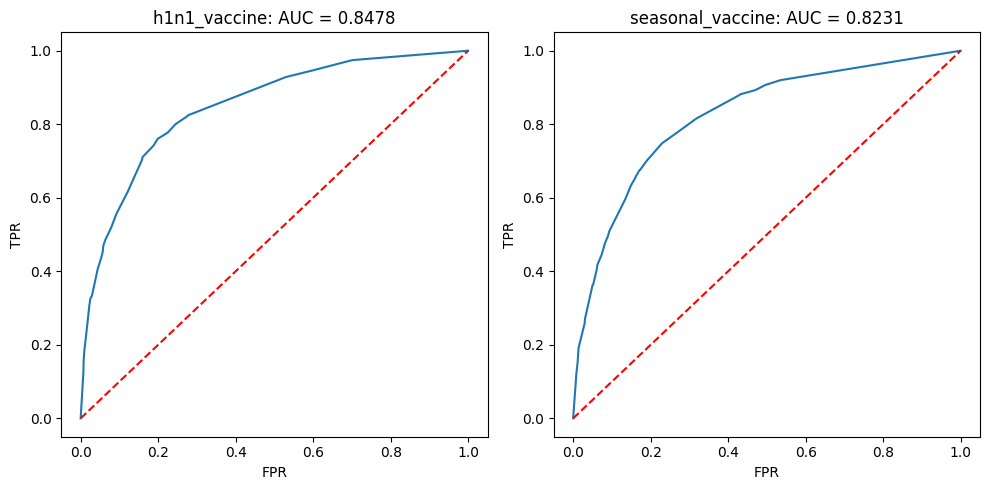

In [14]:
# ROC Curve Plotting
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plot_roc(
    y_test['h1n1_vaccine'],
    y_preds['h1n1_vaccine'],
    'h1n1_vaccine',
    ax=ax[0]
)

plot_roc(
    y_test['seasonal_vaccine'],
    y_preds['seasonal_vaccine'],
    'seasonal_vaccine',
    ax=ax[1]
)

fig.tight_layout()

Explanation:
    ROC curves for both targets.

Justification:
    Visualizes the model’s ability to distinguish between classes.

Interpretation:

h1n1_vaccine: AUC = 0.8478:
    This curve shows a good performance, with an AUC close to 0.9. This indicates that the model is better than random guessing and can effectively distinguish between positive and negative cases.

seasonal_vaccine: AUC = 0.8231:
    This curve also shows good performance, but slightly lower than the h1n1_vaccine model. However, the AUC is still significantly above 0.5, indicating a better performance than random guessing.

In [16]:
# Generate binary predictions from probabilities using a threshold of 0.5
threshold = 0.5
h1n1_binary_preds = (y_preds['h1n1_vaccine'] > threshold).astype(int)
seasonal_binary_preds = (y_preds['seasonal_vaccine'] > threshold).astype(int)



In [17]:
# Confusion Matrices
h1n1_cm = confusion_matrix(y_test['h1n1_vaccine'], h1n1_binary_preds)
seasonal_cm = confusion_matrix(y_test['seasonal_vaccine'], seasonal_binary_preds)



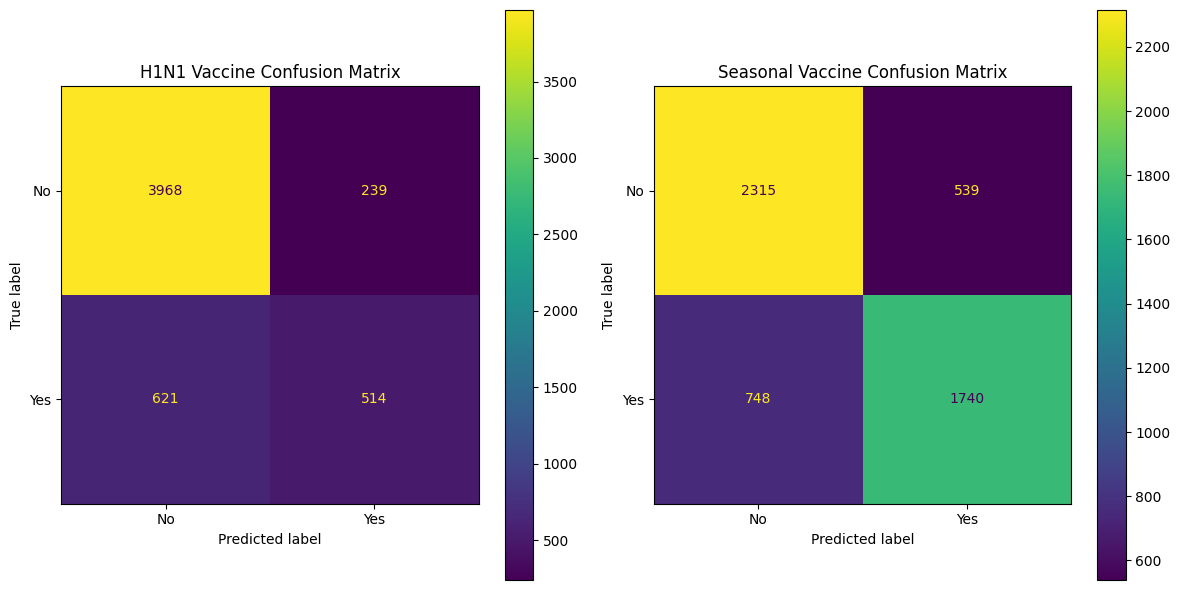

In [18]:
# Plot Confusion Matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay(h1n1_cm, display_labels=["No", "Yes"]).plot(ax=ax[0])
ax[0].set_title("H1N1 Vaccine Confusion Matrix")

ConfusionMatrixDisplay(seasonal_cm, display_labels=["No", "Yes"]).plot(ax=ax[1])
ax[1].set_title("Seasonal Vaccine Confusion Matrix")

plt.tight_layout()
plt.show()

Explanation:
    Evaluates model predictions against true labels using confusion matrices.

Justification:
    Helps interpret false positives, false negatives, and overall classification performance.

Explanation of H1N1 Vaccine Confusion Matrix:
    True Positives: 3968 correctly predicted "No" for H1N1 vaccine
    True Negatives: 514 correctly predicted "Yes" for H1N1 vaccine
    False Positives: 239 incorrectly predicted "Yes" for H1N1 vaccine when it was "No"
    False Negatives: 621 incorrectly predicted "No" for H1N1 vaccine when it was "Yes"

Explanation of Seasonal Vaccine Confusion Matrix:
    True Positives: 2315 correctly predicted "No" for Seasonal vaccine
    True Negatives: 1740 correctly predicted "Yes" for Seasonal vaccine
    False Positives: 539 incorrectly predicted "Yes" for Seasonal vaccine when it was "No"
    False Negatives: 748 incorrectly predicted "No" for Seasonal vaccine when it was "Yes"

Interpretation:
    H1N1 Vaccine: The model seems to have a higher number of True Positives (correctly predicting "No") compared to True Negatives. This might indicate a bias towards predicting the negative class. The False Negative rate is also relatively high, which means the model misses a significant number of cases where the actual response is "Yes".
    Seasonal Vaccine: The model appears to be more balanced in terms of True Positives and True Negatives. The False Negative rate is still relatively high, but lower than that of the H1N1 vaccine.

In [19]:
# Final Model Fitting on Full Training Data
best_estimator.fit(X_train_df, training_set_labels_df)
preds = best_estimator.predict_proba(X_test_df)

Explanation:
    The code retrains the model on the entire training dataset for final predictions.

Justification:
    It maximizes the use of available data for better performance on unseen test data

In [20]:
# Generate Final Predictions
y_preds = pd.DataFrame(
    {
        'h1n1_vaccine': preds[0][:, 1],
        'seasonal_vaccine': preds[1][:, 1],
    },
    index=X_test_df.index
)
print('y_preds.shape:', y_preds.shape)

y_preds.shape: (26708, 2)


Explanation: 
    We convert the final predictions into a DataFrame.

In [21]:
# Save Predictions to CSV
y_preds.to_csv('D:\\Uni_Bamberg\\En_el_extranjero\\UCLM\\ML\\ML\\src\\pred_decision_tree_output.csv', index=True)